In [1]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# ---------------- STEP 1: Generate Dataset ---------------- #

fake = Faker()
np.random.seed(42)
random.seed(42)

N = 80000
product_types = ['Life', 'Health', 'Auto', 'Home', 'Travel']
occupations = ['Engineer', 'Doctor', 'Teacher', 'Lawyer', 'Sales', 'Retired', 'Unemployed']
genders = ['Male', 'Female', 'Other']
regions = ['North', 'South', 'East', 'West', 'Central']
recommendation_types = ['upsell', 'cross-sell', 'none']

def recommend(existing_products):
    if not existing_products:
        return random.choice(product_types), 'none'
    elif len(existing_products) == 1:
        return random.choice([p for p in product_types if p != existing_products[0]]), random.choices(['cross-sell', 'upsell'], [0.7, 0.3])[0]
    elif len(existing_products) == 2:
        return random.choice(product_types), random.choice(['cross-sell', 'upsell'])
    else:
        return random.choice(existing_products), 'upsell'

data = []
for _ in range(N):
    age = random.randint(18, 75)
    gender = random.choice(genders)
    income = round(np.random.normal(70000, 25000))
    occupation = random.choice(occupations)
    region = random.choice(regions)
    num_products = random.choices([0, 1, 2, 3], weights=[0.1, 0.5, 0.3, 0.1])[0]
    existing_products = random.sample(product_types, num_products)
    tenure = round(np.random.exponential(3), 2) if num_products > 0 else 0.0
    total_claims = random.randint(0, 10)
    web_visits = random.randint(0, 20)
    support_calls = random.randint(0, 5)
    
    recommended_product, recommendation_type = recommend(existing_products)

    data.append({
        'age': age,
        'gender': gender,
        'income': income,
        'occupation': occupation,
        'region': region,
        'policy_tenure_years': tenure,
        'total_claims': total_claims,
        'web_visits_last_month': web_visits,
        'support_calls_last_month': support_calls,
        'existing_products': ",".join(existing_products),
        'recommended_product': recommended_product,
        'recommendation_type': recommendation_type
    })

df = pd.DataFrame(data)

# ---------------- STEP 2: Preprocessing ---------------- #

# Remove rows with missing targets (if any)
df.dropna(subset=['recommended_product', 'recommendation_type'], inplace=True)

# Convert list-like column to numeric
df['num_existing_products'] = df['existing_products'].apply(lambda x: len(str(x).split(',')) if x else 0)
df.drop('existing_products', axis=1, inplace=True)

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['gender', 'occupation', 'region'])

# Encode target labels
le_prod = LabelEncoder()
le_type = LabelEncoder()
df['recommended_product_encoded'] = le_prod.fit_transform(df['recommended_product'])
df['recommendation_type_encoded'] = le_type.fit_transform(df['recommendation_type'])

# Final feature set
X_prod = df.drop(['recommended_product', 'recommendation_type',
                  'recommended_product_encoded', 'recommendation_type_encoded'], axis=1)
y_prod = df['recommended_product_encoded']
y_type = df['recommendation_type_encoded']

# ---------------- STEP 3: Train Product Recommendation Model ---------------- #

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_prod, y_prod, test_size=0.2, random_state=42)

clf_prod = RandomForestClassifier(n_estimators=100, random_state=42)
clf_prod.fit(X_train_p, y_train_p)
y_pred_p = clf_prod.predict(X_test_p)

print("\n🎯 Product Recommendation Model:")
print(classification_report(y_test_p, y_pred_p, target_names=le_prod.classes_))
print("Accuracy:", accuracy_score(y_test_p, y_pred_p))

# ---------------- STEP 4: Train Recommendation Type Model ---------------- #

# Remove "num_existing_products" to avoid feature leakage
X_type = X_prod.drop('num_existing_products', axis=1)

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_type, y_type, test_size=0.2, random_state=42)

clf_type = RandomForestClassifier(n_estimators=100, random_state=42)
clf_type.fit(X_train_t, y_train_t)
y_pred_t = clf_type.predict(X_test_t)

print("\n🎯 Recommendation Type Model:")
print(classification_report(y_test_t, y_pred_t, target_names=le_type.classes_))
print("Accuracy:", accuracy_score(y_test_t, y_pred_t))



🎯 Product Recommendation Model:
              precision    recall  f1-score   support

        Auto       0.19      0.21      0.20      3202
      Health       0.20      0.20      0.20      3205
        Home       0.20      0.20      0.20      3189
        Life       0.20      0.21      0.20      3231
      Travel       0.19      0.17      0.18      3173

    accuracy                           0.20     16000
   macro avg       0.20      0.20      0.20     16000
weighted avg       0.20      0.20      0.20     16000

Accuracy: 0.1979375

🎯 Recommendation Type Model:
              precision    recall  f1-score   support

  cross-sell       0.55      0.75      0.64      7943
        none       0.98      1.00      0.99      1624
      upsell       0.45      0.25      0.32      6433

    accuracy                           0.57     16000
   macro avg       0.66      0.67      0.65     16000
weighted avg       0.55      0.57      0.55     16000

Accuracy: 0.57425


# Should I remove none from Recomedation type

In [3]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.5 MB 1.1 MB/s eta 0:00:02
   ------------- -------------------------- 0.5/1.5 MB 4.4 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.5 MB 9.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 8.4 MB/s eta 0:00:00



🎯 XGBoost - Product Recommendation:
              precision    recall  f1-score   support

        Auto       0.20      0.20      0.20      3202
      Health       0.20      0.19      0.19      3205
        Home       0.20      0.19      0.19      3189
        Life       0.21      0.23      0.22      3231
      Travel       0.19      0.19      0.19      3173

    accuracy                           0.20     16000
   macro avg       0.20      0.20      0.20     16000
weighted avg       0.20      0.20      0.20     16000

Accuracy: 0.1988125


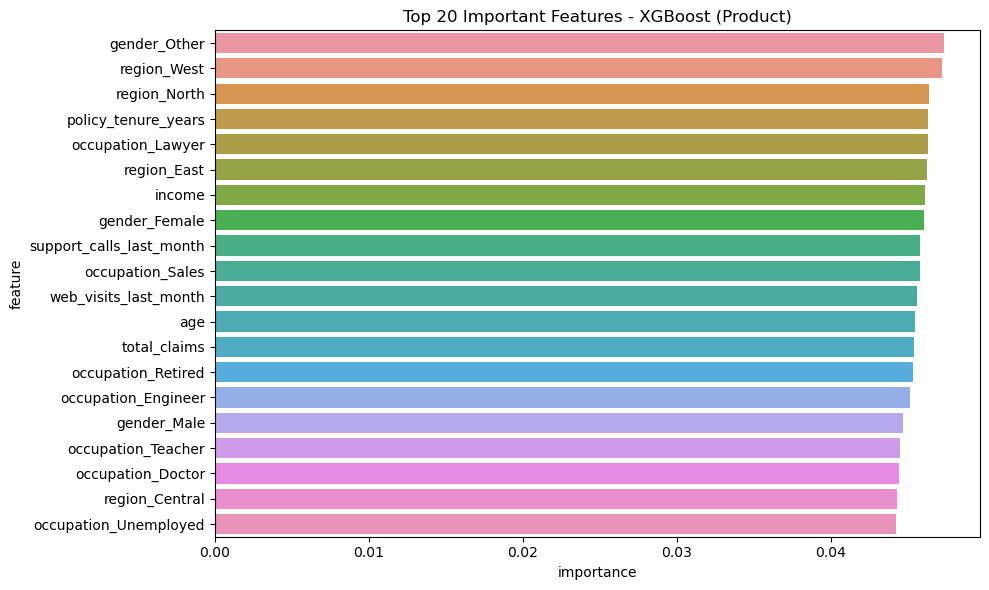

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 21
[LightGBM] [Info] Start training from score -0.690650
[LightGBM] [Info] Start training from score -2.313109
[LightGBM] [Info] Start training from score -0.916799

🎯 LightGBM - Recommendation Type:
              precision    recall  f1-score   support

  cross-sell       0.55      0.94      0.70      7943
        none       0.98      1.00      0.99      1624
      upsell       0.45      0.06      0.10      6433

    accuracy                           0.59     16000
   macro avg       0.66      0.67      0.60     16000
weighted avg       0.56      0.59      0.49     16000

Accuracy: 0.592


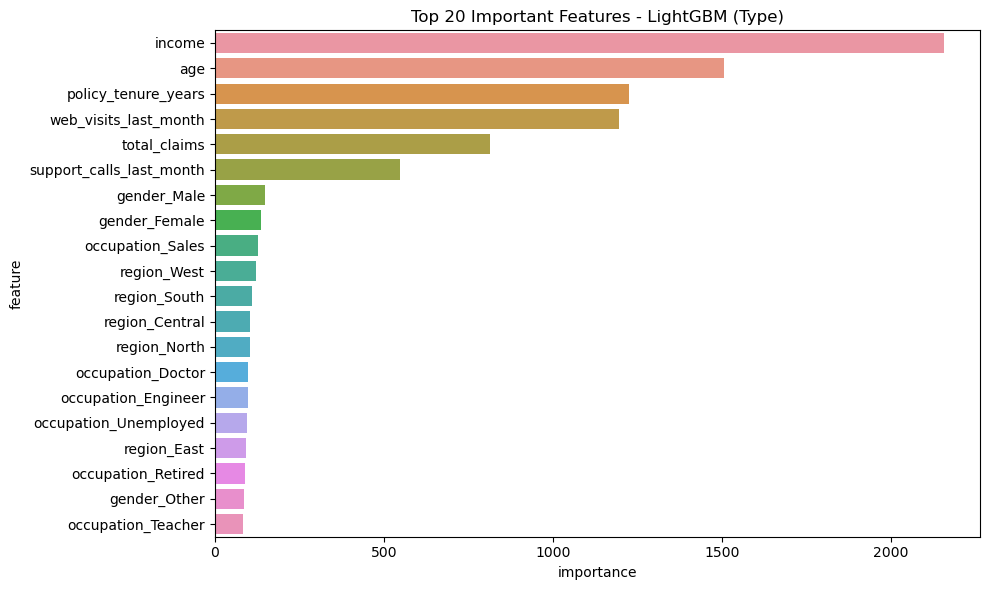

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from faker import Faker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# ------------------ 1. Data Generation ------------------ #
fake = Faker()
np.random.seed(42)
random.seed(42)

N = 80000
product_types = ['Life', 'Health', 'Auto', 'Home', 'Travel']
occupations = ['Engineer', 'Doctor', 'Teacher', 'Lawyer', 'Sales', 'Retired', 'Unemployed']
genders = ['Male', 'Female', 'Other']
regions = ['North', 'South', 'East', 'West', 'Central']

def recommend(existing_products):
    if not existing_products:
        return random.choice(product_types), 'none'
    elif len(existing_products) == 1:
        return random.choice([p for p in product_types if p != existing_products[0]]), random.choices(['cross-sell', 'upsell'], [0.7, 0.3])[0]
    elif len(existing_products) == 2:
        return random.choice(product_types), random.choice(['cross-sell', 'upsell'])
    else:
        return random.choice(existing_products), 'upsell'

data = []
for _ in range(N):
    age = random.randint(18, 75)
    gender = random.choice(genders)
    income = round(np.random.normal(70000, 25000))
    occupation = random.choice(occupations)
    region = random.choice(regions)
    num_products = random.choices([0, 1, 2, 3], weights=[0.1, 0.5, 0.3, 0.1])[0]
    existing_products = random.sample(product_types, num_products)
    tenure = round(np.random.exponential(3), 2) if num_products > 0 else 0.0
    total_claims = random.randint(0, 10)
    web_visits = random.randint(0, 20)
    support_calls = random.randint(0, 5)

    recommended_product, recommendation_type = recommend(existing_products)

    data.append({
        'age': age,
        'gender': gender,
        'income': income,
        'occupation': occupation,
        'region': region,
        'policy_tenure_years': tenure,
        'total_claims': total_claims,
        'web_visits_last_month': web_visits,
        'support_calls_last_month': support_calls,
        'existing_products': ",".join(existing_products),
        'recommended_product': recommended_product,
        'recommendation_type': recommendation_type
    })

df = pd.DataFrame(data)

# ------------------ 2. Preprocessing ------------------ #
df.dropna(subset=['recommended_product', 'recommendation_type'], inplace=True)
df['num_existing_products'] = df['existing_products'].apply(lambda x: len(str(x).split(',')) if x else 0)
df.drop(['existing_products'], axis=1, inplace=True)

# One-hot encoding
df = pd.get_dummies(df, columns=['gender', 'occupation', 'region'])

# Label encoding targets
le_prod = LabelEncoder()
le_type = LabelEncoder()
df['recommended_product_encoded'] = le_prod.fit_transform(df['recommended_product'])
df['recommendation_type_encoded'] = le_type.fit_transform(df['recommendation_type'])

# Define feature and target sets
X = df.drop(['recommended_product', 'recommendation_type',
             'recommended_product_encoded', 'recommendation_type_encoded'], axis=1)
y_product = df['recommended_product_encoded']
y_type = df['recommendation_type_encoded']

# ------------------ 3. XGBoost for Product Recommendation ------------------ #
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y_product, test_size=0.2, random_state=42)

xgb_model_prod = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model_prod.fit(X_train_p, y_train_p)
y_pred_xgb = xgb_model_prod.predict(X_test_p)

print("\n🎯 XGBoost - Product Recommendation:")
print(classification_report(y_test_p, y_pred_xgb, target_names=le_prod.classes_))
print("Accuracy:", accuracy_score(y_test_p, y_pred_xgb))

# ------------------ Feature Importance Plot for XGBoost ------------------ #
def plot_feature_importance(model, feature_names, title):
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False).head(20)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_feature_importance(xgb_model_prod, X.columns, "Top 20 Important Features - XGBoost (Product)")

# ------------------ 4. LightGBM for Recommendation Type ------------------ #
X_type = X.drop(columns=['num_existing_products'], errors='ignore')
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_type, y_type, test_size=0.2, random_state=42)

lgbm_model_type = LGBMClassifier(random_state=42)
lgbm_model_type.fit(X_train_t, y_train_t)
y_pred_lgbm = lgbm_model_type.predict(X_test_t)

print("\n🎯 LightGBM - Recommendation Type:")
print(classification_report(y_test_t, y_pred_lgbm, target_names=le_type.classes_))
print("Accuracy:", accuracy_score(y_test_t, y_pred_lgbm))

# ------------------ Feature Importance Plot for LightGBM ------------------ #
plot_feature_importance(lgbm_model_type, X_type.columns, "Top 20 Important Features - LightGBM (Type)")


In [7]:
import pandas as pd
import numpy as np
import random
from faker import Faker
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Step 1: Generate Realistic Dataset
fake = Faker()
np.random.seed(42)
random.seed(42)

N = 80000
product_types = ['Life', 'Health', 'Auto', 'Home', 'Travel']
occupations = ['Engineer', 'Doctor', 'Teacher', 'Lawyer', 'Sales', 'Retired', 'Unemployed']
genders = ['Male', 'Female', 'Other']
regions = ['North', 'South', 'East', 'West', 'Central']

def recommend(existing_products):
    if not existing_products:
        return random.choice(product_types), 'none'
    elif len(existing_products) == 1:
        return random.choice([p for p in product_types if p != existing_products[0]]), random.choices(['cross-sell', 'upsell'], [0.7, 0.3])[0]
    elif len(existing_products) == 2:
        return random.choice(product_types), random.choice(['cross-sell', 'upsell'])
    else:
        return random.choice(existing_products), 'upsell'

data = []
for _ in range(N):
    age = random.randint(18, 75)
    gender = random.choice(genders)
    income = round(np.random.normal(70000, 25000))
    occupation = random.choice(occupations)
    region = random.choice(regions)
    num_products = random.choices([0, 1, 2, 3], weights=[0.1, 0.5, 0.3, 0.1])[0]
    existing_products = random.sample(product_types, num_products)
    tenure = round(np.random.exponential(3), 2) if num_products > 0 else 0.0
    total_claims = random.randint(0, 10)
    web_visits = random.randint(0, 20)
    support_calls = random.randint(0, 5)

    # New Features
    avg_claim_amount = np.random.normal(1000, 300)
    claims_ratio = total_claims / tenure if tenure > 0 else 0
    engagement_score = web_visits + support_calls

    recommended_product, recommendation_type = recommend(existing_products)

    data.append({
        'age': age,
        'gender': gender,
        'income': income,
        'occupation': occupation,
        'region': region,
        'policy_tenure_years': tenure,
        'total_claims': total_claims,
        'avg_claim_amount': avg_claim_amount,
        'claims_ratio': claims_ratio,
        'engagement_score': engagement_score,
        'web_visits_last_month': web_visits,
        'support_calls_last_month': support_calls,
        'num_existing_products': len(existing_products),
        'recommended_product': recommended_product,
        'recommendation_type': recommendation_type
    })

df = pd.DataFrame(data)

# Step 2: Preprocessing
df = pd.get_dummies(df, columns=['gender', 'occupation', 'region'])
le_prod = LabelEncoder()
le_type = LabelEncoder()
df['recommended_product_encoded'] = le_prod.fit_transform(df['recommended_product'])
df['recommendation_type_encoded'] = le_type.fit_transform(df['recommendation_type'])

# Define features and targets
X = df.drop(columns=['recommended_product', 'recommendation_type', 'recommended_product_encoded', 'recommendation_type_encoded'])
y_prod = df['recommended_product_encoded']
y_type = df['recommendation_type_encoded']

# Train/test splits
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y_prod, test_size=0.2, random_state=42)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y_type, test_size=0.2, random_state=42)

# Balanced sample weights
sample_weight_p = compute_sample_weight(class_weight='balanced', y=y_train_p)
sample_weight_t = compute_sample_weight(class_weight='balanced', y=y_train_t)

# Model 1: XGBoost for Product Recommendation
xgb_model_prod = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model_prod.fit(X_train_p, y_train_p, sample_weight=sample_weight_p)
y_pred_prod = xgb_model_prod.predict(X_test_p)

# Model 2: LightGBM for Recommendation Type
lgbm_model_type = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm_model_type.fit(X_train_t, y_train_t, sample_weight=sample_weight_t)
y_pred_type = lgbm_model_type.predict(X_test_t)

# Evaluation
print("\n🎯 XGBoost - Product Recommendation:")
print(classification_report(y_test_p, y_pred_prod, target_names=le_prod.classes_))
print("Accuracy:", accuracy_score(y_test_p, y_pred_prod))

print("\n🎯 LightGBM - Recommendation Type:")
print(classification_report(y_test_t, y_pred_type, target_names=le_type.classes_))
print("Accuracy:", accuracy_score(y_test_t, y_pred_type))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1177
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 25
[LightGBM] [Info] Start training from score -1.990514
[LightGBM] [Info] Start training from score -0.368055
[LightGBM] [Info] Start training from score -1.764365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

🎯 XGBoost - Product Recommendation:
              precision    recall  f1-score   support

        Auto       0.20      0.20      0.20      3202
      Health       0.21      0.20      0.20      3205
        Home       0.20      0.20      0.20      3189
        Life       0.20      0.20      0.20      3231
      Travel       0.19      0.19      0.19      3173

    accuracy                           0.20     16000
   macro avg       0.20      0.20      0.20     16000
wei

In [1]:
import pandas as pd
import numpy as np
from faker import Faker
import random

fake = Faker()

# Constants
N = 80000
product_types = ['Life', 'Health', 'Auto', 'Home', 'Travel']
occupations = ['Engineer', 'Doctor', 'Teacher', 'Lawyer', 'Sales', 'Retired', 'Unemployed']
genders = ['Male', 'Female', 'Other']
regions = ['North', 'South', 'East', 'West', 'Central']
recommendation_types = ['upsell', 'cross-sell', 'none']

# Function to randomly recommend a product
def recommend_product(existing_products):
    if len(existing_products) == 0:
        return random.choice(product_types), 'none'
    elif len(existing_products) == 1:
        return random.choice([p for p in product_types if p != existing_products[0]]), 'cross-sell'
    elif len(existing_products) == 2:
        return random.choice(existing_products), 'upsell'
    else:
        return 'None', 'none'

# Create dataset
data = []

for i in range(N):
    age = random.randint(18, 75)
    gender = random.choice(genders)
    income = round(np.random.normal(70000, 25000))
    occupation = random.choice(occupations)
    region = random.choice(regions)
    zip_code = fake.zipcode()
    num_products = random.choices([0, 1, 2, 3], weights=[0.1, 0.4, 0.3, 0.2])[0]
    existing_products = random.sample(product_types, num_products)
    tenure = round(np.random.exponential(scale=3), 2) if num_products > 0 else 0.0
    total_claims = random.randint(0, 10)
    web_visits = random.randint(0, 20)
    support_calls = random.randint(0, 5)
    
    recommended_product, recommendation_type = recommend_product(existing_products)

    data.append({
        'customer_id': fake.uuid4(),
        'age': age,
        'gender': gender,
        'income': income,
        'occupation': occupation,
        'region': region,
        'zip_code': zip_code,
        'existing_products': ",".join(existing_products),
        'policy_tenure_years': tenure,
        'total_claims': total_claims,
        'web_visits_last_month': web_visits,
        'support_calls_last_month': support_calls,
        'recommended_product': recommended_product,
        'recommendation_type': recommendation_type
    })

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_excel('insurance_customer_info_80k.xlsx', index=False)

print("✅ Dataset of 80,000 records generated and saved.")


✅ Dataset of 80,000 records generated and saved.


In [2]:
df = pd.read_excel('insurance_customer_info_80k.xlsx')

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
df = pd.read_excel('insurance_customer_info_80k.xlsx')

# Drop rows with missing target values instead of filling them
df = df.dropna(subset=['recommended_product', 'recommendation_type'])

# Clean and convert existing_products to product count
df['existing_products'] = df['existing_products'].fillna("")
df['num_existing_products'] = df['existing_products'].apply(lambda x: len(str(x).split(',')) if x else 0)
df.drop('existing_products', axis=1, inplace=True)

# Drop unneeded columns
df.drop(['customer_id', 'zip_code'], axis=1, inplace=True)

# One-hot encode input features
categorical_features = ['gender', 'occupation', 'region']
df = pd.get_dummies(df, columns=categorical_features)

# Encode target columns
label_encoder_prod = LabelEncoder()
df['recommended_product_encoded'] = label_encoder_prod.fit_transform(df['recommended_product'])

label_encoder_type = LabelEncoder()
df['recommendation_type_encoded'] = label_encoder_type.fit_transform(df['recommendation_type'])

# Drop original string labels
df.drop(['recommended_product', 'recommendation_type'], axis=1, inplace=True)

# --------------------- Product Recommendation Model ---------------------
X_prod = df.drop(['recommended_product_encoded', 'recommendation_type_encoded'], axis=1)
y_prod = df['recommended_product_encoded']
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_prod, y_prod, test_size=0.2, random_state=42)

model_product = RandomForestClassifier(n_estimators=100, random_state=42)
model_product.fit(X_train_p, y_train_p)
y_pred_p = model_product.predict(X_test_p)

print("\n🎯 Product Recommendation Model:")
print(classification_report(y_test_p, y_pred_p, target_names=label_encoder_prod.classes_))
print("Accuracy:", accuracy_score(y_test_p, y_pred_p))

# --------------------- Recommendation Type Model ---------------------

# Optional: Remove num_existing_products if it's too predictive
X_type = df.drop(['recommended_product_encoded', 'recommendation_type_encoded'], axis=1)  # Optionally drop 'num_existing_products'
y_type = df['recommendation_type_encoded']
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_type, y_type, test_size=0.2, random_state=42)

model_type = RandomForestClassifier(n_estimators=100, random_state=42)
model_type.fit(X_train_t, y_train_t)
y_pred_t = model_type.predict(X_test_t)

print("\n🎯 Recommendation Type Model:")
print(classification_report(y_test_t, y_pred_t, target_names=label_encoder_type.classes_))
print("Accuracy:", accuracy_score(y_test_t, y_pred_t))



🎯 Product Recommendation Model:
              precision    recall  f1-score   support

        Auto       0.20      0.21      0.21      2545
      Health       0.19      0.20      0.20      2573
        Home       0.22      0.22      0.22      2552
        Life       0.20      0.21      0.20      2560
      Travel       0.21      0.19      0.20      2583

    accuracy                           0.20     12813
   macro avg       0.20      0.20      0.20     12813
weighted avg       0.20      0.20      0.20     12813

Accuracy: 0.2028408647467416

🎯 Recommendation Type Model:
              precision    recall  f1-score   support

  cross-sell       1.00      1.00      1.00      6395
        none       1.00      1.00      1.00      1595
      upsell       1.00      1.00      1.00      4823

    accuracy                           1.00     12813
   macro avg       1.00      1.00      1.00     12813
weighted avg       1.00      1.00      1.00     12813

Accuracy: 1.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
df = pd.read_csv("insurance_customer_info_80k.csv")

# Drop rows with missing target values instead of filling them
df = df.dropna(subset=['recommended_product', 'recommendation_type'])

# Clean and convert existing_products to product count
df['existing_products'] = df['existing_products'].fillna("")
df['num_existing_products'] = df['existing_products'].apply(lambda x: len(str(x).split(',')) if x else 0)
df.drop('existing_products', axis=1, inplace=True)

# Drop unneeded columns
df.drop(['customer_id', 'zip_code'], axis=1, inplace=True)

# One-hot encode input features
categorical_features = ['gender', 'occupation', 'region']
df = pd.get_dummies(df, columns=categorical_features)

# Encode target columns
label_encoder_prod = LabelEncoder()
df['recommended_product_encoded'] = label_encoder_prod.fit_transform(df['recommended_product'])

label_encoder_type = LabelEncoder()
df['recommendation_type_encoded'] = label_encoder_type.fit_transform(df['recommendation_type'])

# Drop original string labels
df.drop(['recommended_product', 'recommendation_type'], axis=1, inplace=True)

# --------------------- Product Recommendation Model ---------------------
X_prod = df.drop(['recommended_product_encoded', 'recommendation_type_encoded'], axis=1)
y_prod = df['recommended_product_encoded']
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_prod, y_prod, test_size=0.2, random_state=42)

model_product = RandomForestClassifier(n_estimators=100, random_state=42)
model_product.fit(X_train_p, y_train_p)
y_pred_p = model_product.predict(X_test_p)

print("\n🎯 Product Recommendation Model:")
print(classification_report(y_test_p, y_pred_p, target_names=label_encoder_prod.classes_))
print("Accuracy:", accuracy_score(y_test_p, y_pred_p))

# --------------------- Recommendation Type Model ---------------------

# Optional: Remove num_existing_products if it's too predictive
X_type = df.drop(['recommended_product_encoded', 'recommendation_type_encoded'], axis=1)  # Optionally drop 'num_existing_products'
y_type = df['recommendation_type_encoded']
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_type, y_type, test_size=0.2, random_state=42)

model_type = RandomForestClassifier(n_estimators=100, random_state=42)
model_type.fit(X_train_t, y_train_t)
y_pred_t = model_type.predict(X_test_t)

print("\n🎯 Recommendation Type Model:")
print(classification_report(y_test_t, y_pred_t, target_names=label_encoder_type.classes_))
print("Accuracy:", accuracy_score(y_test_t, y_pred_t))
